In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import datetime
import hashlib
import pickle
import copy
import time
import glob
import ast
import os 

from collections import (
    defaultdict,
    deque, 
    OrderedDict
)


from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score
)

from typing import (
    Callable,
    Iterable,
    List
)

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

from sklearn.preprocessing import (
    MultiLabelBinarizer, 
    LabelEncoder, 
    LabelBinarizer, 
    StandardScaler
)
import librosa
import librosa.display

from PIL import Image
import copy

from tqdm import tqdm_notebook as tqdm


from sklearn.metrics import (
    confusion_matrix, 
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

# Dataset Loader Functions

In [2]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
        >>> import utils
        >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
        >>> utils.get_audio_path(AUDIO_DIR, 2)
        '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

# Audio Processing Functions

In [3]:
def mel_spectrom_transformer(audio_file_path):
    y, sr = librosa.load(audio_file_path)
    spect = librosa.feature.melspectrogram(
        y = y,
        sr = sr,
        n_fft = 2048,
        hop_length = 512
    )

    return librosa.power_to_db(spect, ref=np.max)

def plot_spectrom(audio_dir, track_id = 36096):
    filename = get_audio_path(
        audio_dir,
        track_id
    )
    
    spect = mel_spectrom_transformer(filename)

    each_file = filename.split('/')[-1]
    genre_name = each_file.split('.')[0]
    
    
    plt.figure(figsize=(10, 4))
    
    librosa.display.specshow(
        spect,
        y_axis='mel', 
        fmax=8000, 
        x_axis='time'
    )
    
    plt.colorbar(format='%+2.0f dB')
    plt.title(tracks.loc[int(genre_name)]['track']['genre_top'])
    plt.show()
    
def audio_path_to_label(filename):
    each_file = filename.split('/')[-1]
    genre_name = each_file.split('.')[0]
    return tracks.loc[int(genre_name)]['track']['genre_top']

def get_audio_paths(audio_dir):
    audio_files_dir = sorted(os.listdir(audio_dir))
    audio_files_dir = [audio_folder for audio_folder in audio_files_dir if audio_folder.isdigit()]
    audio_file_paths = [
        glob.glob(os.path.join(audio_dir, path, '*.mp3')) for path in audio_files_dir
    ]
    
    return list(itertools.chain.from_iterable(audio_file_paths))

# Load Data

In [4]:
audio_dir = '../data/fma_small'

tracks = load('../data/fma_metadata/tracks.csv')
features = load('../data/fma_metadata/features.csv')
echonest = load('../data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']
features_all = features.join(echonest, how='inner').sort_index(axis=1)

tracks = tracks.loc[subset]
features_all = features.loc[subset]

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

In [5]:
print(train.shape, val.shape, test.shape)

(6400,) (800,) (800,)


In [6]:
genres = LabelEncoder().fit(tracks['track', 'genre_top']).classes_

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

# Audio File x Label Matching

In [7]:
df_audio = pd.DataFrame()
df_audio['audio_paths'] = get_audio_paths(audio_dir)
df_audio['genre_top'] = df_audio['audio_paths'].apply(audio_path_to_label)

In [8]:
df_audio.to_csv('../data/audio-label-mapping.csv', index = False)

In [9]:
df_audio = pd.read_csv('../data/audio-label-mapping.csv')
df_audio

audio_paths genre_top
0     ../data/fma_small/000/000010.mp3       Pop
1     ../data/fma_small/000/000212.mp3      Folk
2     ../data/fma_small/000/000574.mp3      Rock
3     ../data/fma_small/000/000825.mp3      Rock
4     ../data/fma_small/000/000602.mp3      Folk
...                                ...       ...
7995  ../data/fma_small/154/154306.mp3   Hip-Hop
7996  ../data/fma_small/154/154307.mp3   Hip-Hop
7997  ../data/fma_small/154/154305.mp3   Hip-Hop
7998  ../data/fma_small/154/154303.mp3   Hip-Hop
7999  ../data/fma_small/155/155066.mp3   Hip-Hop

[8000 rows x 2 columns]

# Mel Spectrum Visualization

/Users/cankocagil/miniforge_x86_64/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


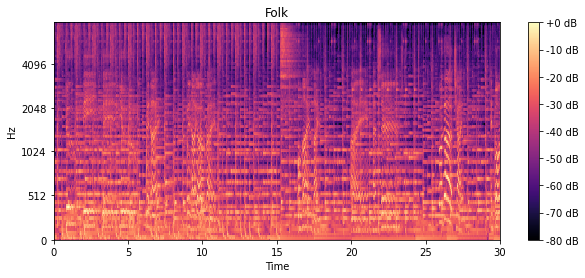

In [33]:
plot_spectrom(audio_dir, track_id=212)

In [12]:
filename = get_audio_path(
    audio_dir,
    2
)

y, sr = librosa.load(filename)


/Users/cankocagil/miniforge_x86_64/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [20]:
spect = mel_spectrom_transformer(filename)

/Users/cankocagil/miniforge_x86_64/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Text(0.5, 1.0, 'Hip-hop Wave Plot')

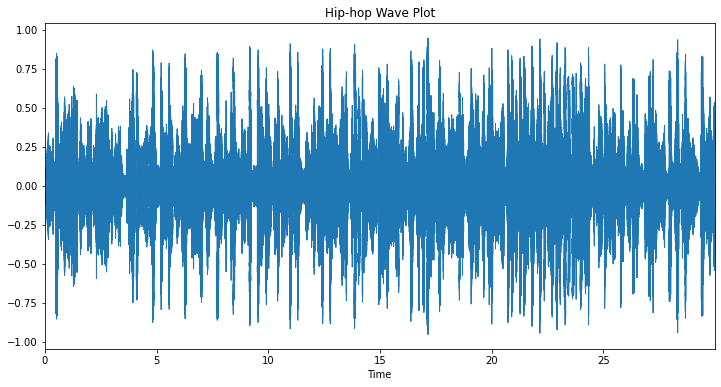

In [14]:
plt.figure(figsize=(12, 6))
whale_song, _ = librosa.effects.trim(y)
librosa.display.waveplot(whale_song, sr=sr)
plt.title('Hip-hop Wave Plot')

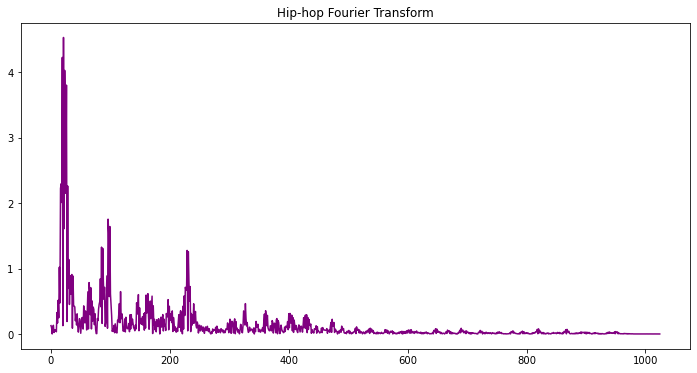

In [15]:
plt.figure(figsize=(12, 6))
n_fft = 2048
D = np.abs(librosa.stft(whale_song[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.title('Hip-hop Fourier Transform')
plt.plot(D, color = 'purple')

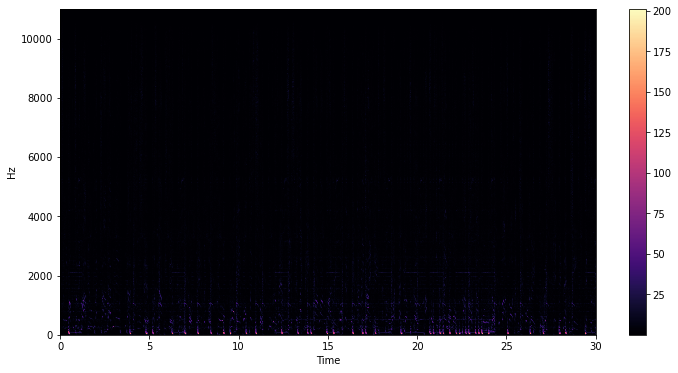

In [16]:
plt.figure(figsize=(12, 6))
hop_length = 512
D = np.abs(librosa.stft(whale_song, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar()

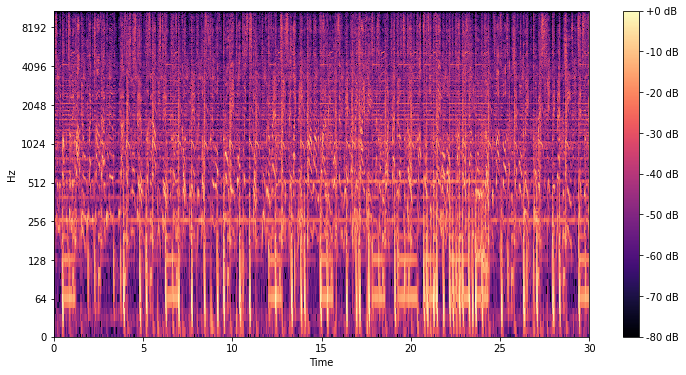

In [17]:
plt.figure(figsize=(12, 6))
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB')

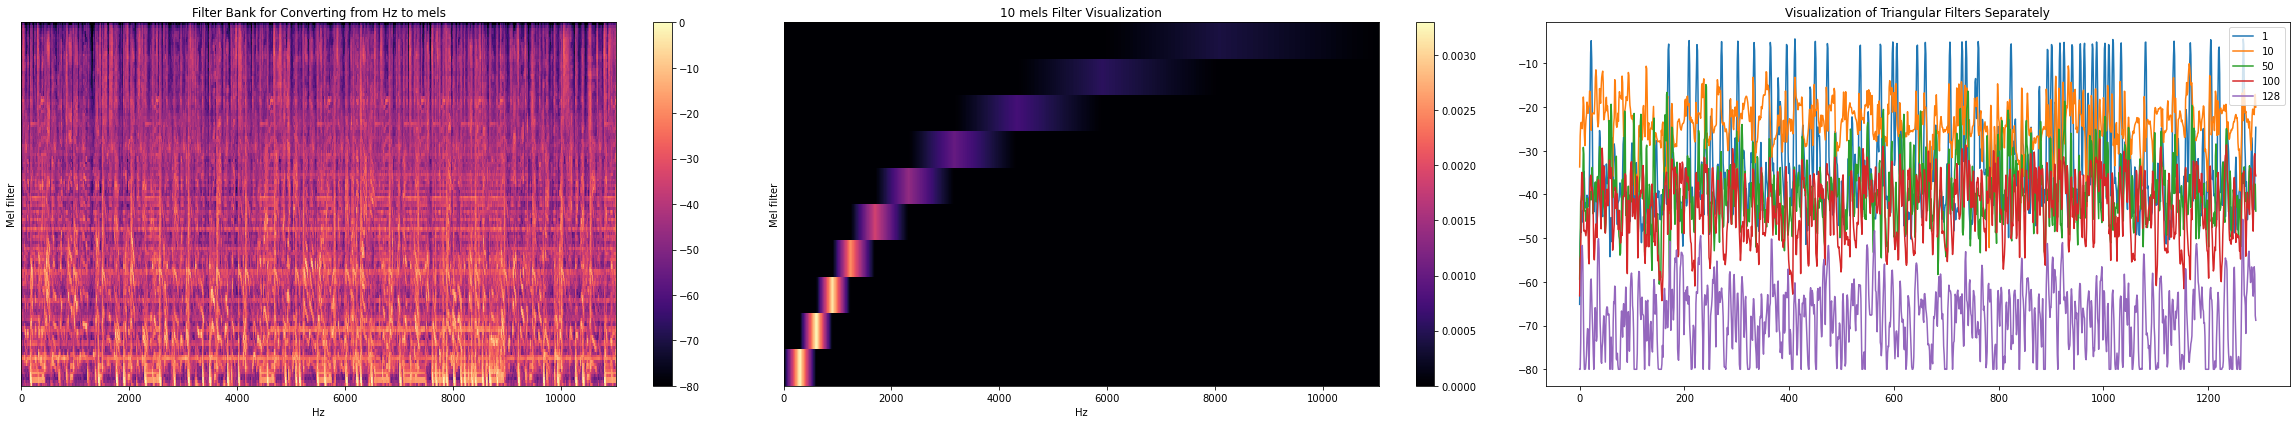

In [32]:
plt.figure(figsize=(32, 6));

mel = spect

plt.subplot(1, 3, 1);
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('Filter Bank for Converting from Hz to mels');

plt.subplot(1, 3, 2);
mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('10 mels Filter Visualization');

plt.subplot(1, 3, 3);
idxs_to_plot = [0, 9, 49, 99, 127]
for i in idxs_to_plot:
    plt.plot(mel[i]);
plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
plt.title('Visualization of Triangular Filters Separately');

plt.tight_layout();

# Deep Modelling of Mel Spectrums

In [35]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim


from torch.utils.data import (
  Dataset,
  DataLoader
)

In [36]:
with open("../data/spectrums/data_points.pickle", "rb") as fp:   # Unpickling
    data_points = pickle.load(fp)

df_audio = pd.DataFrame(data_points, columns=['spectrum', 'genre'])

In [37]:
df_audio['spectrum_shapes'] = df_audio['spectrum'].apply(lambda x: x.shape)
df_audio['spectrum_shapes'].value_counts()

(128, 1292)    4636
(128, 1293)    3355
(128, 1291)       3
(128, 70)         1
(128, 23)         1
(128, 67)         1
Name: spectrum_shapes, dtype: int64

In [38]:
df_audio['genre'].replace({'Hip-Hop':'Hop'}, inplace=True)

In [39]:
print(df_audio['genre'].unique())

['Pop' 'Folk' 'Rock' 'Hop' 'Experimental' 'International' 'Electronic'
 'Instrumental']


# Mel Spectrum Dataset

In [40]:
class VisualSpectrumDataset(Dataset):
    def __init__(
        self, 
        df_audio,
        root_dir=None,
        transform = None
    ) -> None: 

        self.allowable_image_shapes = [(128, 1292, 3), (128, 1293, 3)]
        self.last_dimension = 1292
        self.df_audio = df_audio
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.classes = np.unique(self.df_audio['genre'])
        self.class_encoder = {class_name : idx for idx, class_name in enumerate(self.classes)}
        self.class_decoder = {idx : class_name for class_name, idx  in self.class_encoder.items()}
        
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx) -> ('Image', 'Label'):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()  

        connected = False

        while not connected:

            try:
                image_path = os.path.join(
                    self.root_dir,
                    self.image_paths[idx]
                )
                
                spectrum = plt.imread(image_path)
                
                if spectrum.shape in self.allowable_image_shapes:
                    spectrum = spectrum[:, : self.last_dimension, :]

                    spectrum = Image.fromarray(spectrum)

                    connected = True
                    
                else:
                    pass

            except:
                idx = np.random.randint(len(self.image_paths))

        label = self.class_encoder[
            self.image_path_to_label(image_path)
        ]

        if self.transform is not None:
            spectrum = self.transform(spectrum)
            
        return spectrum, label
        
    def image_path_to_label(self, image_path):
        return image_path.split('/')[-1].split('-')[-1].split('.')[0]


class SpectrumDataset(Dataset):
    def __init__(
        self, 
        df_spect_path: str = '../data/spectrums/spectrum-label-mapping.feather',
        transform = None
    ) -> None: 
        
        self.df_audio = pd.read_csv(df_spect_path)
        self.classes = np.unique(self.df_audio['genre_top'])
        self.class_encoder = {class_name : idx for idx, class_name in enumerate(self.classes)}
        self.class_decoder = {idx : class_name for class_name, idx  in self.class_encoder.items()}
        
        self.transform = transform
        
    def __len__(self):
        return len(self.df_audio)
    
    def __getitem__(self, idx) -> ('Image', 'Label'):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()  
            
        data = self.df_audio.iloc[idx]
        
        spectrum = Image.open(data['spectrum_paths'])
        
        label = self.class_encoder[data['genre_top']]
        
        if self.transform is not None:
            spectrum = self.transform(spectrum)

        return spectrum, label

In [41]:
class PyTMinMaxScalerVectorized(object):
    """
    Transforms each channel to the range [0, 1].
    """
    def __call__(self, tensor):
        dist = (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0])
        dist[dist==0.] = 1.
        scale = 1.0 /  dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        return tensor

class MinMaxNormalizer:
    def __init__(self, feature_range = (0, 1)):
        self.feature_range = feature_range
        
    def __call__(self, X):
        new_min, new_max = self.feature_range
        min_pixel = X.min()
        max_pixel = X.max()
        
        return (X - min_pixel) / (max_pixel - min_pixel) * (new_max - new_min) + new_min

In [42]:
dataset = VisualSpectrumDataset(
  df_audio = df_audio,
  root_dir = '../data/spectrums/visuals',
  transform = transforms.Compose([        
    transforms.ToTensor(), 
  ])
)

# Dataset Split (To-Do: Follow Paper Guidelines)

In [43]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

splitted_data = torch.utils.data.random_split(
  dataset, 
  [train_size, val_size, test_size]
)

In [44]:
batch_size = 4

train_data, val_data, test_data = tuple([
    DataLoader(
        subset,
        batch_size = batch_size,
        shuffle = True, 
        #num_workers = 2 * num_GPU,
        #pin_memory = True
    ) for subset in splitted_data
])

In [45]:
x, y = next(iter(train_data))

In [46]:
x.shape, y.shape

(torch.Size([4, 3, 128, 1292]), torch.Size([4]))

# Simple ConvNet Just Representative - TBC

In [64]:
class ConvNet(nn.Module):
    def __init__(self, num_class:int = 8): 
        super(ConvNet, self).__init__()

        self.conv_layers = nn.Sequential(*[
                nn.Sequential(
                        nn.Conv2d(3, 4, 3, 1, 1),
                        nn.ReLU()
                ),
                nn.Sequential(
                        nn.Conv2d(4, 8, 3, 1, 1),
                        nn.ReLU(),
                        nn.MaxPool2d(2)
                ),
                nn.Sequential(
                        nn.Conv2d(8, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.MaxPool2d(2)
                ),
                nn.Sequential(
                        nn.Conv2d(16, 32, 3, 1, 1),
                        nn.ReLU(),
                        nn.MaxPool2d(2)
                ),
                nn.Sequential(
                        nn.Conv2d(32, 64, 3, 1, 1),
                        nn.ReLU(),
                        nn.MaxPool2d(2)
                ),   
                nn.Sequential(
                        nn.Conv2d(64, 128, 3, 1, 1),
                        nn.ReLU(),
                        nn.MaxPool2d(2)
                ), 
                nn.Sequential(
                        nn.Conv2d(128, 256, 3, 1, 1),
                        nn.ReLU(),
                        nn.MaxPool2d(2)
                ),                               
        ])

        self.flatten = nn.Flatten()
  
        self.classifer = nn.Sequential(
          nn.Linear(10240, 5120),
          nn.ReLU(),
          nn.Linear(5120, num_class)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        return self.classifer(x)
  
print(ConvNet())

ConvNet(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (5): Sequ

In [62]:
from torchviz import make_dot

model = ConvNet()
make_dot(model(x), params=dict(list(model.named_parameters()))).render("ConvNet", format="png")

'ConvNet.png'

In [51]:
import hiddenlayer as hl

transforms = [hl.transforms.Prune('Constant') ]

In [63]:
graph = hl.build_graph(ConvNet(), x, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('ConvNet', format='png')

In [72]:
from torchinfo import summary
model = ConvNet()
batch_size = 16
print(summary(model, input_size=x.shape))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  --                        --
├─Sequential: 1-1                        [4, 256, 2, 20]           --
│    └─Sequential: 2-1                   [4, 4, 128, 1292]         --
│    │    └─Conv2d: 3-1                  [4, 4, 128, 1292]         112
│    │    └─ReLU: 3-2                    [4, 4, 128, 1292]         --
│    └─Sequential: 2-2                   [4, 8, 64, 646]           --
│    │    └─Conv2d: 3-3                  [4, 8, 128, 1292]         296
│    │    └─ReLU: 3-4                    [4, 8, 128, 1292]         --
│    │    └─MaxPool2d: 3-5               [4, 8, 64, 646]           --
│    └─Sequential: 2-3                   [4, 16, 32, 323]          --
│    │    └─Conv2d: 3-6                  [4, 16, 64, 646]          1,168
│    │    └─ReLU: 3-7                    [4, 16, 64, 646]          --
│    │    └─MaxPool2d: 3-8               [4, 16, 32, 323]          --
│    └─Seq

In [ ]:
from vit_pytorch import ViT

v = ViT(
    image_size = 1292,
    patch_size = 4,
    num_classes = 8,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.randn(1, 3, 128, 1292)

preds = v(img) # (1, 8)

# Computing Device

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()

In [74]:
def optimizer_to(optim, device) -> None:
    """ Moving PyTorch Optimizer to device """
    for param in optim.state.values():
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [75]:
splits = [
  'train',
  'val', 
  'test'
]

datasets = [train_data, val_data, test_data]

data = {split: X_y for X_y, split in zip(datasets, splits)}

# Defining Loss Function & Optimizer

In [76]:
criterion = nn.CrossEntropyLoss().to(device)
net = ConvNet().to(device)

learning_rate = 1e-3
optimizer = optim.SGD(
    net.parameters(),
    lr=learning_rate,
    weight_decay=5e-04
)

optimizer_to(optimizer, device)

# Conventional PyTorch Training Utility Functions

In [77]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)
        
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))

def accuracy_(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target[None])

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().sum(dtype=torch.float32)
            res.append(correct_k * (100.0 / batch_size))
        return res

# Per-Epoch Training & Validation

In [78]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value}'))
    metric_logger.add_meter('img/s', SmoothedValue(window_size=10, fmt='{value}'))

    header = 'Epoch: [{}]'.format(epoch)
    for image, target in metric_logger.log_every(data_loader, print_freq, header):
        start_time = time.time()
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc1, acc3 = accuracy_(output, target, topk=(1, 3))
        batch_size = image.shape[0]
        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
        metric_logger.meters['acc3'].update(acc3.item(), n=batch_size)
        metric_logger.meters['img/s'].update(batch_size / (time.time() - start_time))

    return metric_logger


def evaluate(model, criterion, data_loader, device, print_freq=100):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Validation:'
    with torch.no_grad():
        for image, target in metric_logger.log_every(data_loader, print_freq, header):
            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            loss = criterion(output, target)

            acc1, acc3 = accuracy_(output, target, topk=(1, 3))
        
            batch_size = image.shape[0]
            metric_logger.update(loss=loss.item())
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
            metric_logger.meters['acc3'].update(acc3.item(), n=batch_size)
  
    print(' * Acc@1 {top1.global_avg:.3f} Acc@3 {top3.global_avg:.3f}'
          .format(top1=metric_logger.acc1, top3=metric_logger.acc3))
    
    return metric_logger

def open_folder(path:str) -> None:
    if not os.path.exists(path):
        os.mkdir(path)
        print(f"Directory: {path} is created!")

# Main Learning & Validation Loop

In [79]:
def main(
    net: nn.Module,
    criterion,
    optimizer,
    data:dict, 
    device,
    start_epoch: int = 0,
    max_epoch: int = 300,
    save_best_model: bool = True,
    save_every: int = 150, 
    print_freq: int =50, 
    root_dir: str = os.getcwd(),
    model_path: str = 'model',
    best_model_save_path: str = 'best_model.pth',
    loop_decs: str = 'ConvNet Training Loop'
) -> 'dict[nn.Module, dict[MetricLogger]]':
    
    """ Generic Training & Validation Loop """

    model_dir = os.path.join(root_dir, model_path)
    
    open_folder(model_dir)

    start_time = time.time()
    best_net_wts = copy.deepcopy(net.state_dict())
    best_acc = float('-inf')

    metric_cache = {
      'train': [],
      'val': []
    }

    for epoch in tqdm(
      range(start_epoch, max_epoch),
      desc = loop_decs
    ):

      train_metric_logger = train_one_epoch(
          net, 
          criterion, 
          optimizer, 
          data['train'], 
          device, 
          epoch, 
          print_freq=print_freq
      )

      metric_cache['train'].append(train_metric_logger)

      val_metric_logger = evaluate(
          net, 
          criterion, 
          data['val'], 
          device=device
      )
      
      metric_cache['val'].append(val_metric_logger)
    
      val_acc = val_metric_logger.acc1.global_avg

      if save_best_model:
          if val_acc > best_acc:
              best_net_wts = copy.deepcopy(net.state_dict())
              best_acc = val_acc

      
      if epoch % save_every == 0:
          checkpoint = {
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
          }

          save_path = os.path.join(model_dir, f"epoch-{epoch + 1}.pth")
          
          torch.save(
            checkpoint, 
            save_path
          )

          print(f"Checkpoint at epoch [{epoch + 1}/{max_epoch}] is succesfully saved under {save_path}")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f'Training time :{total_time_str}')

    if save_best_model:
        save_best_path = os.path.join(model_dir, best_model_save_path)
        torch.save(best_net_wts, save_best_path)
        best_model_weigths = torch.load(save_best_path)
        net.load_state_dict(best_model_weigths)

    print(f"Best model is loaded succesfully!")

    return {
        'model': net,
        'metric_cache': metric_cache
    }

In [ ]:
out = main(
    net, 
    criterion, 
    optimizer, 
    data, 
    device, 
    start_epoch = 0, 
    max_epoch = 1, 
    save_best_model = True, 
    save_every=100, 
    print_freq=50, 
    root_dir = '/Users/cankocagil/Desktop/Schooling/CS464/Project', 
    model_path = 'model',
    best_model_save_path = 'best_model.pth',
    loop_decs = 'ConvNet Training Loop'
)

# Main Testing Loop

In [ ]:
def main_test(
    net, 
    dataloader,
    metrics:list = [
      accuracy_score, 
      precision_score, 
      recall_score, 
      f1_score
    ],
    metric_params:list = [
      dict(), 
      dict(average='macro'), 
      dict(average='macro'),
      dict(average='macro')
    ],
):

    preds = []
    labels = []

    with torch.no_grad():
        for image, target in dataloader:
            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = net(image)
            pred = output.argmax(1).cpu().numpy()
            label = target.cpu().numpy()
            preds.append(pred)
            labels.append(label)


    y_pred = np.concatenate(preds, axis=0)
    y_true = np.concatenate(labels, axis=0)

    results = {}

    for metric, metric_param in zip(metrics, metric_params):
        results[metric.__name__] = metric(y_true, y_pred, **metric_param)

    return {
      'results_df': pd.DataFrame(results, index = [0]),
      'preds': y_pred,
      'labels': y_true
    }

In [ ]:
net = out['model']
metric_cache = out['metric_cache']
train_metric_cache = metric_cache['train']
val_metric_cache = metric_cache['val']

net.eval().to(device)

results_cache = main_test(
    net, 
    data['test'],
    metrics = [
      accuracy_score, 
      precision_score, 
      recall_score, 
      f1_score
    ],
    metric_params = [
      dict(), 
      dict(average='macro'), 
      dict(average='macro'),
      dict(average='macro')
    ]
)

results_df = results_cache['results_df']
preds = results_cache['preds']
labels = results_cache['labels']
conf_mat = confusion_matrix(labels, preds)

train_loss = [metric_log.loss.global_avg for metric_log in train_metric_cache]
train_acc = [metric_log.acc1.global_avg for metric_log in train_metric_cache]

val_loss = [metric_log.loss.global_avg for metric_log in val_metric_cache]
val_acc = [metric_log.acc1.global_avg for metric_log in val_metric_cache]

In [58]:
class AudioToSpectrumDataset(Dataset):
    def __init__(
        self, 
        df_audio_path: str = '../data/audio-label-mapping.csv',
        transform = None
    ) -> None: 
        
        self.df_audio = pd.read_csv(df_audio_path)
        self.classes = np.unique(self.df_audio['genre_top'])
        self.class_encoder = {class_name : idx for idx, class_name in enumerate(self.classes)}
        self.class_decoder = {idx:class_name for class_name, idx  in self.class_encoder.items()}
        
        self.transform = transform
        
    def __len__(self):
        len(self.df_audio)
    
    def __getitem__(self, idx) -> ('Image', 'Label'):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()  
            
        data = self.df_audio.iloc[idx]
            
        audio_path = data['audio_paths']
        spectrum = self.mel_spectrom_transformer(audio_path)
        
        label = self.class_encoder[data['genre_top']]
        
        if self.transform is not None:
            spectrum = self.transform(spectrum)

        return spectrum, label
    
    def mel_spectrom_transformer(self, audio_file_path):
        y, sr = librosa.load(audio_file_path)
        spect = librosa.feature.melspectrogram(
            y = y,
            sr = sr,
            n_fft = 2048,
            hop_length = 512
        )

        return librosa.power_to_db(
            spect,
            ref=np.max
        )

In [59]:
x, y = next(iter(SpectrumDataset()))

/Users/cankocagil/miniforge_x86_64/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [68]:
np.expand_dims(x, axis = 2).shape

(128, 1292, 1)

In [70]:
transforms.ToTensor()(np.expand_dims(x, axis = 0))

tensor([[[-61.9954, -55.3758, -43.9587,  ..., -55.5944, -57.8781, -71.2974]],

        [[-55.1001, -44.8359, -29.2026,  ..., -46.5051, -49.3707, -62.2156]],

        [[-49.4042, -41.9790, -22.2959,  ..., -44.0186, -48.6933, -60.1943]],

        ...,

        [[-30.3184, -23.0495, -20.2514,  ..., -61.9868, -65.6915, -80.0000]],

        [[-23.5042, -14.5134, -17.2012,  ..., -64.1251, -70.3109, -80.0000]],

        [[-20.8313, -14.9459, -17.2647,  ..., -66.8806, -70.0401, -80.0000]]])